In [170]:
import sys
%pylab inline
import os
import pandas as pd

import re
import json
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
import cvxpy as cp
from scipy import stats


Populating the interactive namespace from numpy and matplotlib


In [171]:
INFINITY = 1e10 # No station value should realistically be higher than this

In [172]:
def objective(x):
    return -np.log(np.diff(x)[::2]).sum()


def clean_solution(solution):
    # Can get an optimal inaccurate solution that doesn't respect the consrtaints.
    # Simple enough to change by forcing y values to be monotonic by raising them
    # Just do a quick check at the end that this "fix" is still a good solution
    y = solution['y']
    z = solution['z']
    c = solution['c']
    clean_y = y.copy()
    sorted_x = c[z]
    for i in range(len(y)):        
        if c[i] == 0:
            clean_y[i] = 0
        elif c[i] == INFINITY:
            clean_y[i] = 1
    for i in range(len(y) - 1):
        if clean_y[z[i+1]] < clean_y[z[i]]:
            clean_y[z[i+1]] = clean_y[z[i]]
    
    if (np.diff(clean_y[z]) < 0).any():
        raise ValueError("Y still not sorted...")
        
    if objective(clean_y) - solution['value'] > 0.1:
        raise ValueError("WARN. Loss of quality!")
    solution['clean_y'] = clean_y

                

In [173]:
def fit(df, partial=False, name=''):
    retval = dict()
    
    n_vars = len(df) * 2
    n_stations = len(df)
    # a is the lower bounds
    a = df['lower_bound_value'] / df['population']
    # b is the upper bounds Make sure that INFINITY isn't different for every station. 
    b = df.apply(lambda row: INFINITY if row['upper_bound_value'] == INFINITY else row['upper_bound_value'] / row['population'], axis=1)
    # Interleave the lower and upper bounds, so the array looks like lb_s, ub_s, lb_s, ub_s...
    c = np.empty((a.size + b.size,), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    z = np.argsort(c) #z[0] is the smallest value's index
    retval['c'] = c
    retval['z'] = z
    retval['name'] = name
    retval['high_bound'] = np.unique(c[z])[-2]
    if partial:
        return retval
        
    # Encode the problem in cvxpy
    x = cp.Variable(n_vars, nonneg=True)
    # CDF non-decreasing constraint
    constraints = [
        x[z[i]] <= x[z[i+1]] for i in range(n_vars - 1)
    ]
    # Final variable is <= 1. (Note that this will constrain every other variable by the above consrtaints)
    constraints += [x[z[n_vars-1]] <= 1 ]

    # Minimize the NLL
    obj = cp.Minimize(-cp.sum(cp.log(cp.diff(x)[::2])))
    problem = cp.Problem(obj, constraints)
    problem.solve(verbose=True, feastol=1e-12, max_iters=1000)
#     problem.is_dcp()
    print(problem.status)
    if problem.status not in ['infeasible', 'unbounded']:
        print("Optimal value: %s" % problem.value)
    y = problem.variables()[0].value
    retval['y'] = y
    retval['value'] = problem.value
    clean_solution(retval)         
    return retval
    



In [180]:
df = pd.read_csv('UHF_Data_v2.csv')
np.random.seed(1234)
y_all = fit(df, name='all')



ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -2.054e+02  +5e+03  8e-01  4e-01  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  -8.422e+00  -1.237e+02  +2e+03  4e-01  3e-01  8e-01  4e-01  0.6464  6e-02   1  1  1 |  0  0
 2  -1.288e+01  -9.524e+01  +1e+03  2e-01  2e-01  6e-01  2e-01  0.5783  3e-01   1  1  1 |  0  0
 3  -3.733e+01  -1.039e+02  +9e+02  2e-01  2e-01  5e-01  2e-01  0.3717  2e-01   1  1  1 |  0  2
 4  -4.224e+01  -1.026e+02  +7e+02  1e-01  1e-01  5e-01  1e-01  0.6266  7e-01   1  1  1 |  7  2
 5  -4.259e+01  -1.003e+02  +7e+02  1e-01  1e-01  5e-01  1e-01  0.2567  7e-01   1  1  1 |  8  6
 6  -3.194e+01  -8.848e+01  +7e+02  1e-01  1e-01  5e-01  1e-01  0.5013  1e+00   1  1  1 | 16  3
 7  -1.472e+01  -7.009e+01  +7e+02  1e-01  1e-01  6e-01  1e-01  0.9791  1e+00   1  1  1 | 33  0
 8  -1.989e+01  -6.939e+01  +6e+02  1e-01  9e-

In [181]:
def interpolater(solution):
    y = solution['clean_y']
    z = solution['z']
    c = solution['c']
    def q(x):
        x_vals = c[z]
        y_vals = y[z]
        return np.interp(x, x_vals, y_vals)
    
    if q(0) != 0:
        raise ValueError("0 is not interpolated right! {q(0)}")
    if np.abs(q(INFINITY) - 1) > 1e-6:
        raise ValueError(f"1 is not interpolated right! {q(INFINITY)}")

    solution['interpolater'] = q


0.10039895159649642 0.2363425582957262
-2.354034126228602 7.6062292440404615


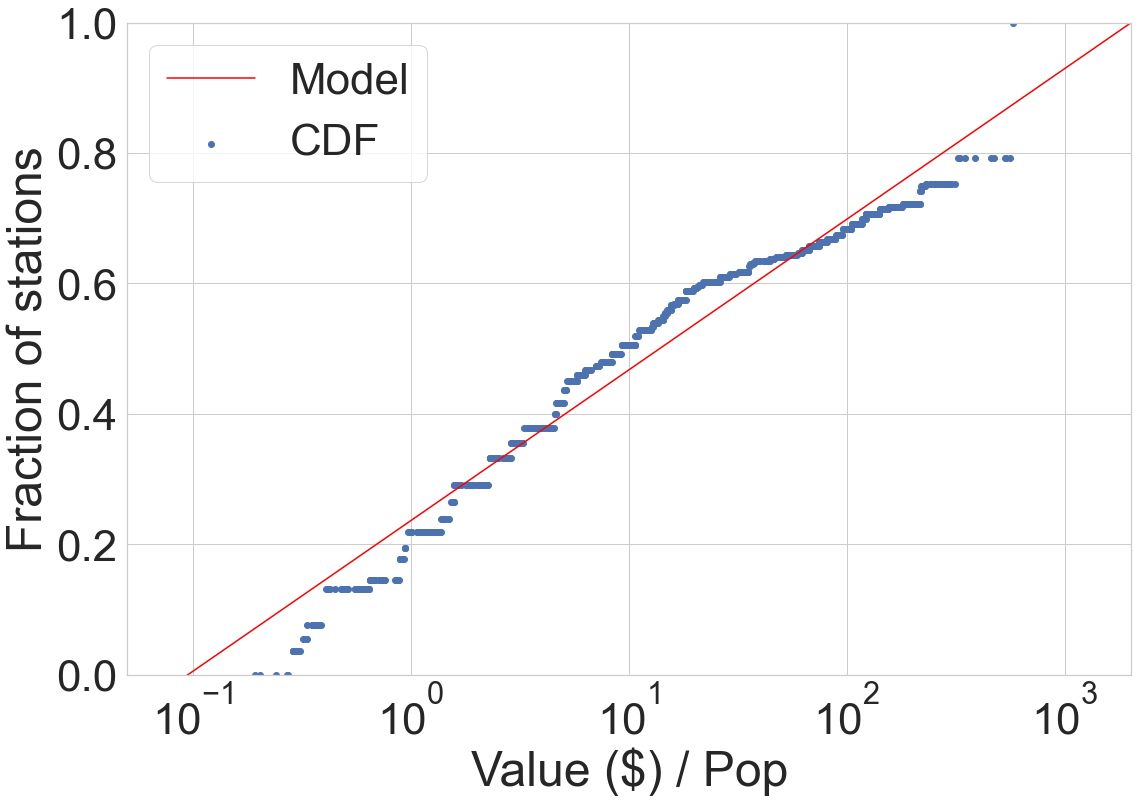

In [182]:
sns.set(font_scale=2)

def derivative_estimate(solution):
    x = np.linspace(0, solution['high_bound'], 100000)
    dx = x[1] - x[0]
    derivative = np.diff(solution['interpolater'](x)) / dx
    return {
        'x': x[1:]-dx/2,
        'y': derivative
    }

def log_uniform_cdf(c, a):
    return lambda x: (np.log(x) - a) / (c-a)

def plot_solution(solution, derivative=False):
    y = solution['clean_y']
    z = solution['z']
    c = solution['c']

    fig = plt.figure(figsize=(18,12))
    sns.set(font_scale=4, style='whitegrid')
    
    # Export for usage elsewhere
#     pd.DataFrame({'y': y}).to_csv('data.csv', index=False, header=False)

    plt.scatter(c, y, label='CDF')
    plt.ylabel('Fraction of stations')
    plt.xlabel('Value ($) / Pop')
    plt.xscale('log')
    plt.xlim(left=1e-1, right=min(solution['high_bound'], 1e5))
    
    idx = np.where((y < 1.) & (y > 0))

    x_data = np.log(c[idx])
    y_data = y[idx]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    def predict(x):
        return slope * np.log(x) + intercept
    
    print(slope, intercept)
    
    x_data = np.logspace(-1,5,10000)
    
    a = -intercept / slope
    c = (1 - intercept) / slope
    
    print(a, c)
    
    x_data = np.logspace(a,c,10000)
    
    plt.plot(x_data, predict(x_data), color='red', label='Model')

    plt.xlim(left=0.05, right=np.exp(c))
    plt.ylim(bottom=0,top=1)
    
    def pdf_func(x):
        return 1 / (x * (c - a))
        
    
    plt.legend(loc='upper left')
    special_save_fig(fig, 'cdf.pdf')

plot_solution(y_all)

/Users/newmanne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


[ 13.47790728 -33.2426527 ]
0.10039895159649642 0.2363425582957262
-2.354034126228602 7.6062292440404615
[ 0.40770941  0.41777196  0.41909244  0.41935208  0.42857718  0.45067905
  0.4771724   0.48640047  0.49065382  0.50239998  0.50969062  0.51625477
  0.55233149  0.55491494  0.56025898  0.56661543  0.57081374  0.57519478
  0.57880553  0.58935339  0.59279297  0.60174762  0.60726019  0.62388912
  0.62706916  0.62808028  0.62997778  0.63745719  0.64170579  0.64691334
  0.6475276   0.6478361   0.65127541  0.66264129  0.67891459  0.68418414
  0.68781671  0.71237838  0.71441278  0.73462877  0.75553369  0.75707515
  0.7641086   0.84572483  0.85633242  0.85833652  0.8632297   0.86823408
  0.87023873  0.88522516  0.89177134  0.89335076  0.8969625   0.90631416
  0.91186016  0.91360928  0.93531763  0.93784414  0.9400758   0.94452512
  0.96633712  0.99651349  1.00123257  1.00990883  1.06393999  1.06642043
  1.08295733  1.0894303   1.0920166   1.10176482  1.10971168  1.11709435
  1.12515341  1.151

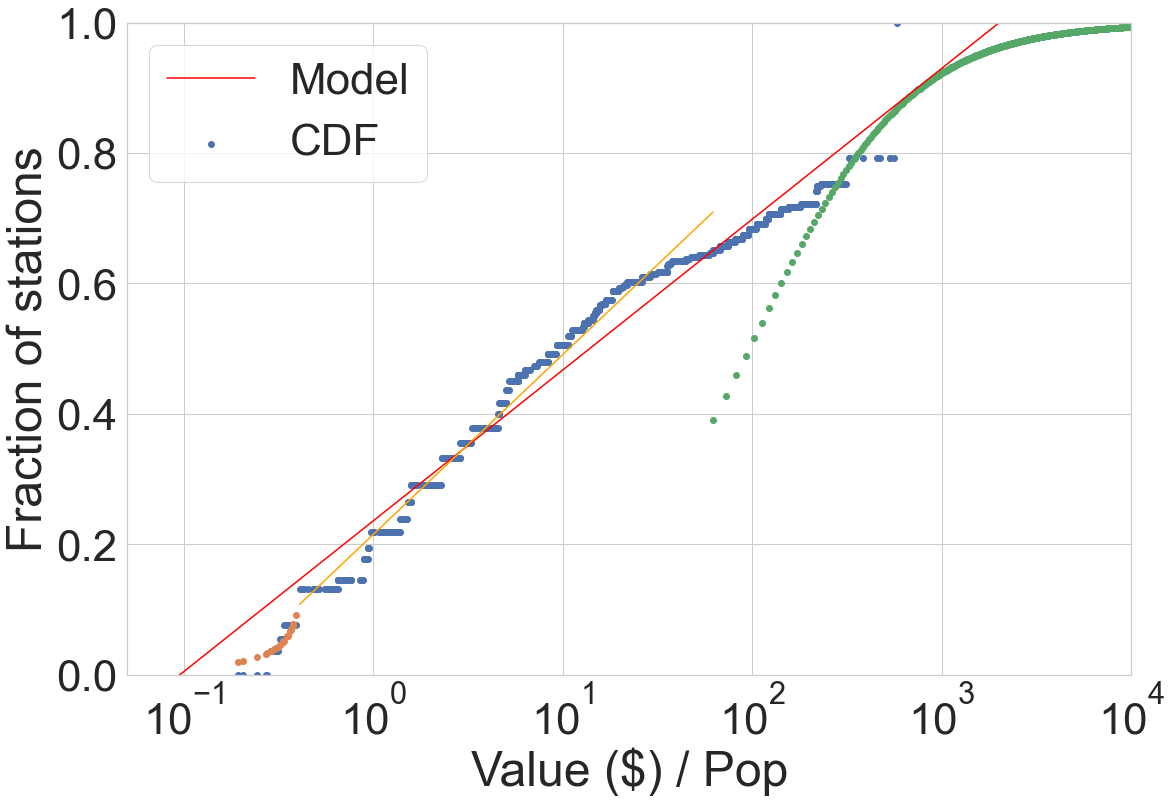

In [183]:
y = y_all['clean_y'].copy()
x = y_all['c'].copy()
_, idx = np.unique(x, return_index=True)
x, y = x[idx], y[idx]

q_left = 0.1
q_right = 0.65
left_idx = np.where(y <= q_left)
right_idx = np.where(y >= q_right)
middle_idx = np.where((y >= q_left) & (y <= q_right))

from scipy.optimize import curve_fit

location = 0
# CDF of generalized pareto distribution
def func(x, scale, shape):
    z = (x - location) / scale
    return 1 - (1 + z * shape) ** (-1/shape)

popt, pcov = curve_fit(func, x[left_idx], y[left_idx], bounds=([0, -np.inf], [np.inf, np.inf]))
print(popt)

plot_solution(y_all)
plt.scatter(x[left_idx], func(x[left_idx], *popt), label='Left Tail')

#location = 0# min(x[right_idx])
# popt, pcov = curve_fit(func, x[right_idx], y[right_idx], bounds=([0, -np.inf], [np.inf, np.inf]))
# print(popt)

popt[0] = 100
popt[1] = 0.9
location = 0#x[right_idx][0]

rlim = 10_000
new_points = np.arange(min(x[right_idx]), rlim, 10)
plt.scatter(new_points, func(new_points, *popt), label='Right Tail')


plt.xlim(right=rlim)


print(x[middle_idx])
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x[middle_idx]), y[middle_idx])
def predict(x):
    return slope * np.log(x) + intercept
plt.plot(x[middle_idx], predict(x[middle_idx]), color='orange')

In [184]:
print(x[-2])

578.5677691125405


(0.0001, 19.473475107429632)

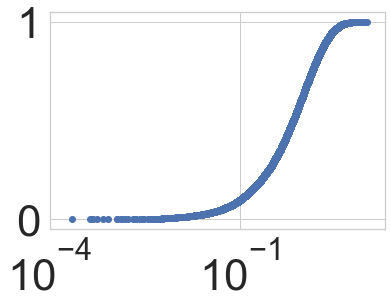

In [185]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(np.random.exponential(1, size=10000))
plt.scatter(ecdf.x, ecdf.y)
plt.xscale('log')
plt.xlim(left=1e-4)

In [186]:
print(x)

[0.00000000e+00 1.92829689e-01 2.04511217e-01 2.41816131e-01
 2.69740812e-01 2.73366620e-01 2.87966369e-01 2.87991978e-01
 2.88663462e-01 2.98230563e-01 3.04561474e-01 3.11768657e-01
 3.19511982e-01 3.31080128e-01 3.32264056e-01 3.34905269e-01
 3.35414284e-01 3.51697392e-01 3.52404591e-01 3.64281840e-01
 3.67272338e-01 3.69336531e-01 3.74214840e-01 3.77563832e-01
 3.89193705e-01 4.07709408e-01 4.17771955e-01 4.19092436e-01
 4.19352078e-01 4.28577179e-01 4.50679049e-01 4.77172396e-01
 4.86400466e-01 4.90653824e-01 5.02399980e-01 5.09690623e-01
 5.16254772e-01 5.52331493e-01 5.54914938e-01 5.60258982e-01
 5.66615425e-01 5.70813738e-01 5.75194778e-01 5.78805526e-01
 5.89353392e-01 5.92792970e-01 6.01747616e-01 6.07260186e-01
 6.23889118e-01 6.27069155e-01 6.28080283e-01 6.29977779e-01
 6.37457193e-01 6.41705794e-01 6.46913344e-01 6.47527602e-01
 6.47836096e-01 6.51275412e-01 6.62641287e-01 6.78914587e-01
 6.84184143e-01 6.87816710e-01 7.12378378e-01 7.14412775e-01
 7.34628773e-01 7.555336